In [22]:
## analyse the data
import mne
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [23]:
raw=mne.io.read_raw_gdf('BCICIV_2a_gdf/A01E.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'])
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

Extracting EDF parameters from C:\Users\HP\Downloads\BCI PROJECT-20220624T090242Z-001\BCI PROJECT\Notebooks\BCI 4\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


C:\Users\HP\miniconda3\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\HP\miniconda3\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01E.gdf, 22 x 687000 (2748.0 s), ~26 kB, data not loaded>

**From the paper**  
'1023': 1 (Rejected trial),   
 '1072': 2 (Eye movements),  
 '276':  3 (eyes open)),  
 '277':  4 (eyes closed),   
 '32766':5 (Start of a new run),  
 '768':  6 (Start of a trial),  
 '769': 7 (class 1),  
 '770': 8 (class 2),  
 '771': 9 (class 3),  
 '772': 10 (class 4)
#### event ids are not same for all subjects

In [24]:
def read_data(path):
    raw=mne.io.read_raw_gdf(path,preload=True,
                          eog=['EOG-left', 'EOG-central', 'EOG-right'])
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    raw.set_eeg_reference()
    events, event_id =mne.events_from_annotations(raw)
    #events[1]['769'],events[1]['770'],events[1]['771'],events[1]['772']
    ann = event_id.keys()
    ann = list(map(int,ann))
    ids = event_id.values()
    ids = list(ids)
    unq = np.unique(events[:,-1])
    for u in unq:
        events[:,-1] = np.where(events[:,-1]== u , ann[u-1],events[:,-1])
    epochs = mne.Epochs(raw, events, event_id=[769,772],
                        tmin= 0, tmax=4,baseline=(None,4), on_missing ='warn')
    labels=epochs.events[:,-1]
    features=epochs.get_data()
    return features,labels

In [25]:
paths = glob.glob('BCICIV_2a_gdf/*T.gdf')
paths

['BCICIV_2a_gdf\\A01T.gdf',
 'BCICIV_2a_gdf\\A02T.gdf',
 'BCICIV_2a_gdf\\A03T.gdf',
 'BCICIV_2a_gdf\\A04T.gdf',
 'BCICIV_2a_gdf\\A05T.gdf',
 'BCICIV_2a_gdf\\A06T.gdf',
 'BCICIV_2a_gdf\\A07T.gdf',
 'BCICIV_2a_gdf\\A08T.gdf',
 'BCICIV_2a_gdf\\A09T.gdf']

In [26]:
%%capture
features,labels,groups=[],[],[]
for i in paths:
    feature,label=read_data(i)
    features.append(feature)
    labels.append(label)
    groups.append([i]*len(label))

In [27]:
features=np.concatenate(features)
labels=np.concatenate(labels)
groups=np.concatenate(groups)

features.shape,labels.shape,groups.shape

((1296, 22, 1001), (1296,), (1296,))

In [28]:
unique, counts = np.unique(groups, return_counts=True)
unique, counts

(array(['BCICIV_2a_gdf\\A01T.gdf', 'BCICIV_2a_gdf\\A02T.gdf',
        'BCICIV_2a_gdf\\A03T.gdf', 'BCICIV_2a_gdf\\A04T.gdf',
        'BCICIV_2a_gdf\\A05T.gdf', 'BCICIV_2a_gdf\\A06T.gdf',
        'BCICIV_2a_gdf\\A07T.gdf', 'BCICIV_2a_gdf\\A08T.gdf',
        'BCICIV_2a_gdf\\A09T.gdf'], dtype='<U22'),
 array([144, 144, 144, 144, 144, 144, 144, 144, 144], dtype=int64))

In [29]:
unique, counts = np.unique(labels, return_counts=True)
unique, counts


(array([769, 772]), array([648, 648], dtype=int64))

# Chronet tensor preparation

In [30]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
#https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

In [31]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [32]:
lb = preprocessing.LabelBinarizer()

#enc_df= enc.fit_transform(dataset['60'])
labels =  lb.fit_transform(labels)

In [33]:
np.unique(labels)

array([0, 1])

In [34]:
data_array = features
label_array = labels
group_array = groups
#data_array=np.moveaxis(data_array,1,2)

In [35]:
scaler=StandardScaler3D()
train_features,val_features,train_labels,val_labels = train_test_split(data_array, label_array, test_size=0.25, random_state=42)
train_features=scaler.fit_transform(train_features)
val_features=scaler.transform(val_features)

In [36]:
train_features.shape, train_labels.shape

((972, 22, 1001), (972, 1))

# EegNet

In [37]:
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,Conv2D,Dropout,BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf
#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chro

In [39]:
from EEGModels import *

In [ ]:
eegnet = EEGNet(1, features.shape[1],features.shape[2],dropoutRate = 0.4)
eegnet.summary()

In [19]:
eegnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss = 'binary_crossentropy',metrics=['accuracy'])

In [20]:
eegnet_history = eegnet.fit(train_features, train_labels,epochs=30,batch_size=100,validation_data=(val_features, val_labels))

Epoch 1/30
10/10 [==============================] - 20s 2s/step - loss: 0.6666 - accuracy: 0.5051 - val_loss: 0.6783 - val_accuracy: 0.4846
Epoch 2/30
10/10 [==============================] - 17s 2s/step - loss: 0.5754 - accuracy: 0.5051 - val_loss: 0.6432 - val_accuracy: 0.4846
Epoch 3/30
10/10 [==============================] - 17s 2s/step - loss: 0.5192 - accuracy: 0.5051 - val_loss: 0.6035 - val_accuracy: 0.4846
Epoch 4/30
10/10 [==============================] - 17s 2s/step - loss: 0.4671 - accuracy: 0.5051 - val_loss: 0.5779 - val_accuracy: 0.4846
Epoch 5/30
10/10 [==============================] - 17s 2s/step - loss: 0.4496 - accuracy: 0.5051 - val_loss: 0.5328 - val_accuracy: 0.4846
Epoch 6/30
10/10 [==============================] - 17s 2s/step - loss: 0.4369 - accuracy: 0.5051 - val_loss: 0.5045 - val_accuracy: 0.4846
Epoch 7/30
10/10 [==============================] - 17s 2s/step - loss: 0.4209 - accuracy: 0.5051 - val_loss: 0.4851 - val_accuracy: 0.4846
Epoch 8/30
10/10 [==

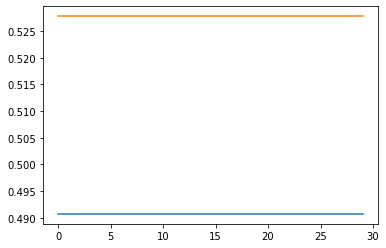

In [31]:
plt.plot(eegnet_history.history["accuracy"])
plt.plot(eegnet_history.history["val_accuracy"])

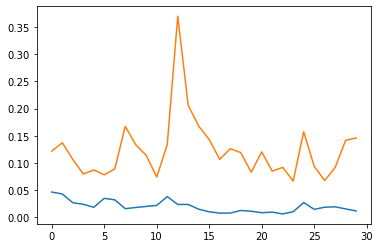

In [32]:
plt.plot(eegnet_history.history["loss"])
plt.plot(eegnet_history.history["val_loss"])

# Binary Class Class accuaracies

In [52]:
model = eegnet

C:\Users\uabhi\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\uabhi\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\uabhi\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       481
           1       0.51      1.00      0.67       491

    accuracy                           0.51       972
   macro avg       0.25      0.50      0.34       972
weighted avg       0.26      0.51      0.34       972



<AxesSubplot:>

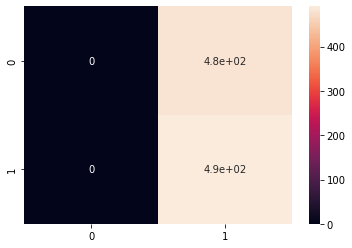

In [53]:
# classification report on training set
y_p = []
pred = model.predict_on_batch(train_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = train_labels.reshape(train_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.48      1.00      0.65       157

    accuracy                           0.48       324
   macro avg       0.24      0.50      0.33       324
weighted avg       0.23      0.48      0.32       324



C:\Users\uabhi\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\uabhi\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\uabhi\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

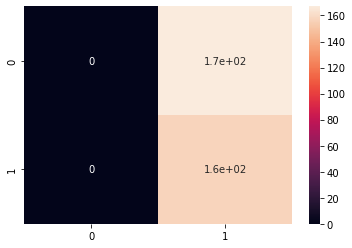

In [54]:
# classification report on validation set
y_p = []
pred = model.predict_on_batch(val_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = val_labels.reshape(val_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

# Multiclass class accuracies

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1284

    accuracy                           1.00      1284
   macro avg       1.00      1.00      1.00      1284
weighted avg       1.00      1.00      1.00      1284



<AxesSubplot:>

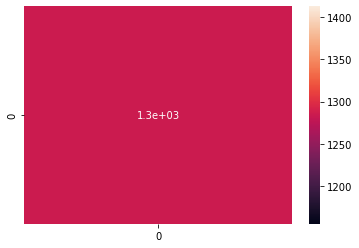

In [166]:
y_t = np.argmax(val_labels, axis=1) # Convert one-hot to index
pred = model.predict_on_batch(val_features)
y_p = np.argmax(pred,axis=1)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2604

    accuracy                           1.00      2604
   macro avg       1.00      1.00      1.00      2604
weighted avg       1.00      1.00      1.00      2604



<AxesSubplot:>

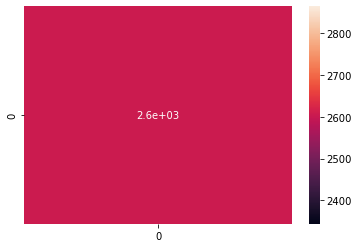

In [167]:
y_t = np.argmax(train_labels, axis=1) # Convert one-hot to index
pred = model.predict_on_batch(train_features)
y_p = np.argmax(pred,axis=1)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

In [70]:
y_p = model.predict_on_batch(val_features)

In [71]:
np.count_nonzero(val_labels)

157

In [72]:
len(val_labels)

324